In [68]:
import arviz as az
import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
seed: int = sum(map(ord, "birthdays"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [15]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/avehtari/casestudies/master/Birthdays/data/births_usa_1969.csv",
)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   year          7305 non-null   int64
 1   month         7305 non-null   int64
 2   day           7305 non-null   int64
 3   births        7305 non-null   int64
 4   day_of_year   7305 non-null   int64
 5   day_of_week   7305 non-null   int64
 6   id            7305 non-null   int64
 7   day_of_year2  7305 non-null   int64
dtypes: int64(8)
memory usage: 456.7 KB


In [16]:
raw_df.head()

,year,month,day,births,day_of_year,day_of_week,id,day_of_year2
0,1969,1,1,8486,1,3,1,1
1,1969,1,2,9002,2,4,2,2
2,1969,1,3,9542,3,5,3,3
3,1969,1,4,8960,4,6,4,4
4,1969,1,5,8390,5,7,5,5


In [17]:
data_df = raw_df.copy().assign(
    date=lambda x: pd.to_datetime(x[["year", "month", "day"]]),
    births_relative100=lambda x: x["births"] / x["births"].mean() * 100,
)

data_df.head()

,year,month,day,births,day_of_year,day_of_week,id,day_of_year2,date,births_relative100
0,1969,1,1,8486,1,3,1,1,1969-01-01,87.947483
1,1969,1,2,9002,2,4,2,2,1969-01-02,93.295220
2,1969,1,3,9542,3,5,3,3,1969-01-03,98.891690
3,1969,1,4,8960,4,6,4,4,1969-01-04,92.859939
4,1969,1,5,8390,5,7,5,5,1969-01-05,86.952555


Text(0.5, 1.0, 'Relative Births in the USA in 1969')

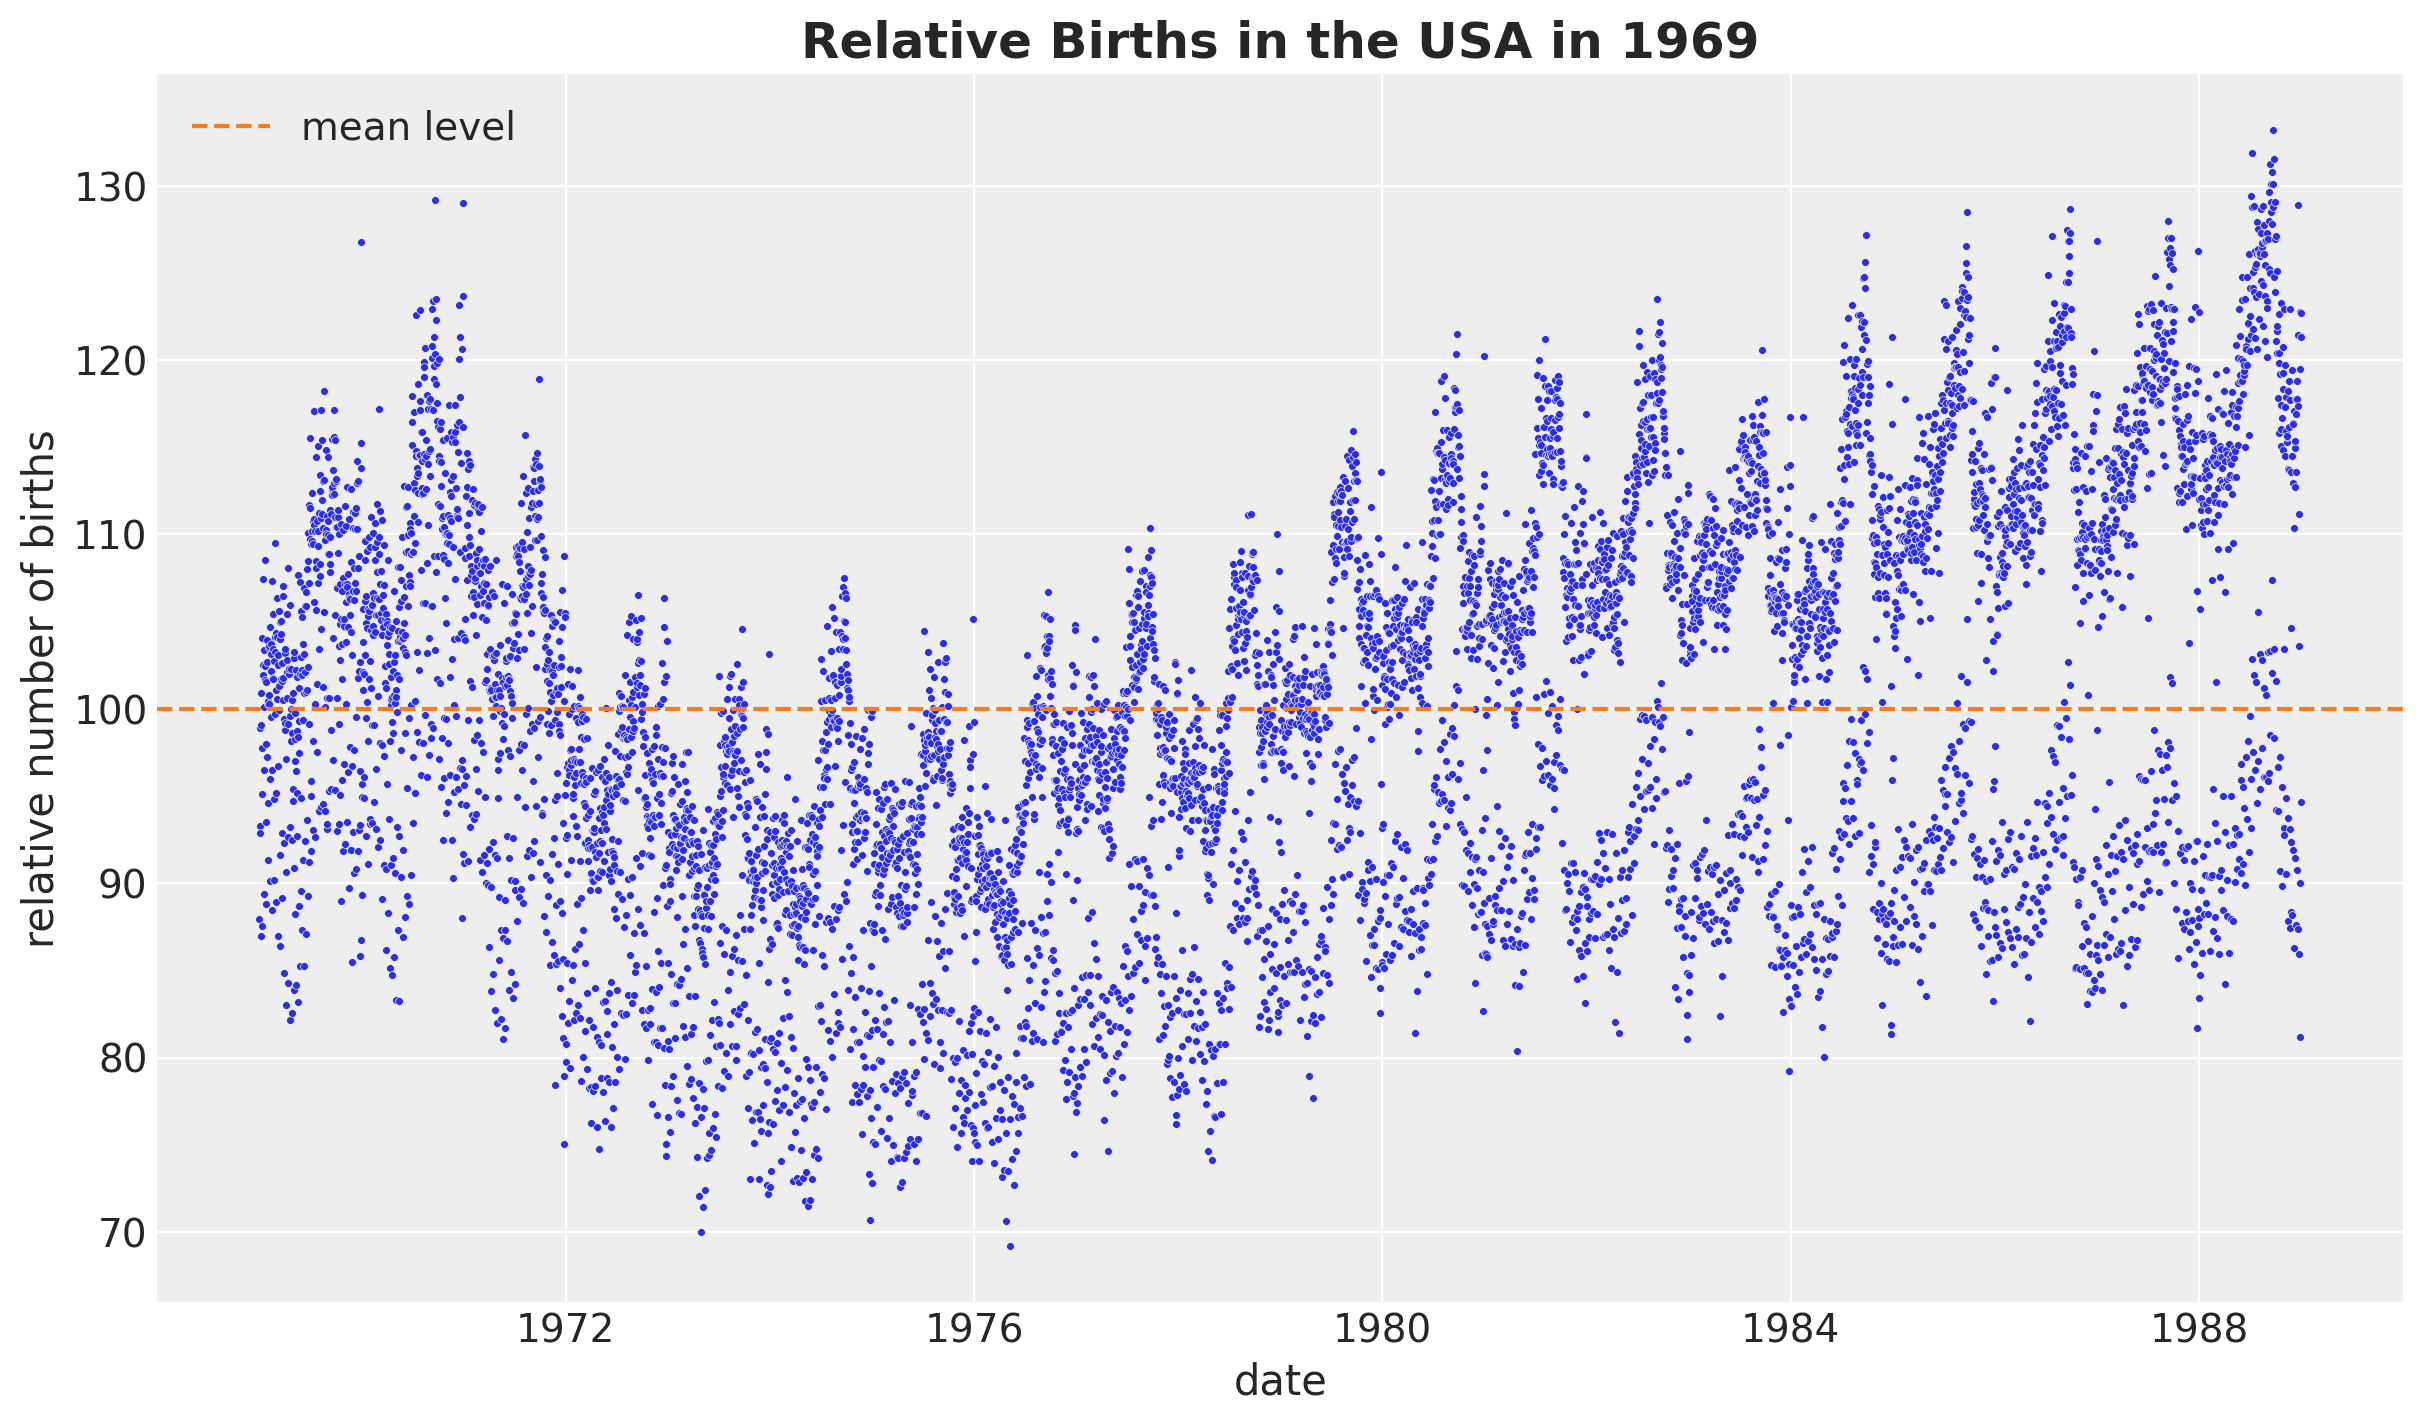

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="date", y="births_relative100", c="C0", s=8, ax=ax)
ax.axhline(100, color="C1", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="date", ylabel="relative number of births")
ax.set_title(label="Relative Births in the USA in 1969", fontsize=18, fontweight="bold")

[Text(0.5, 0, 'day of year'),
 Text(0, 0.5, 'relative number of births per day of year')]

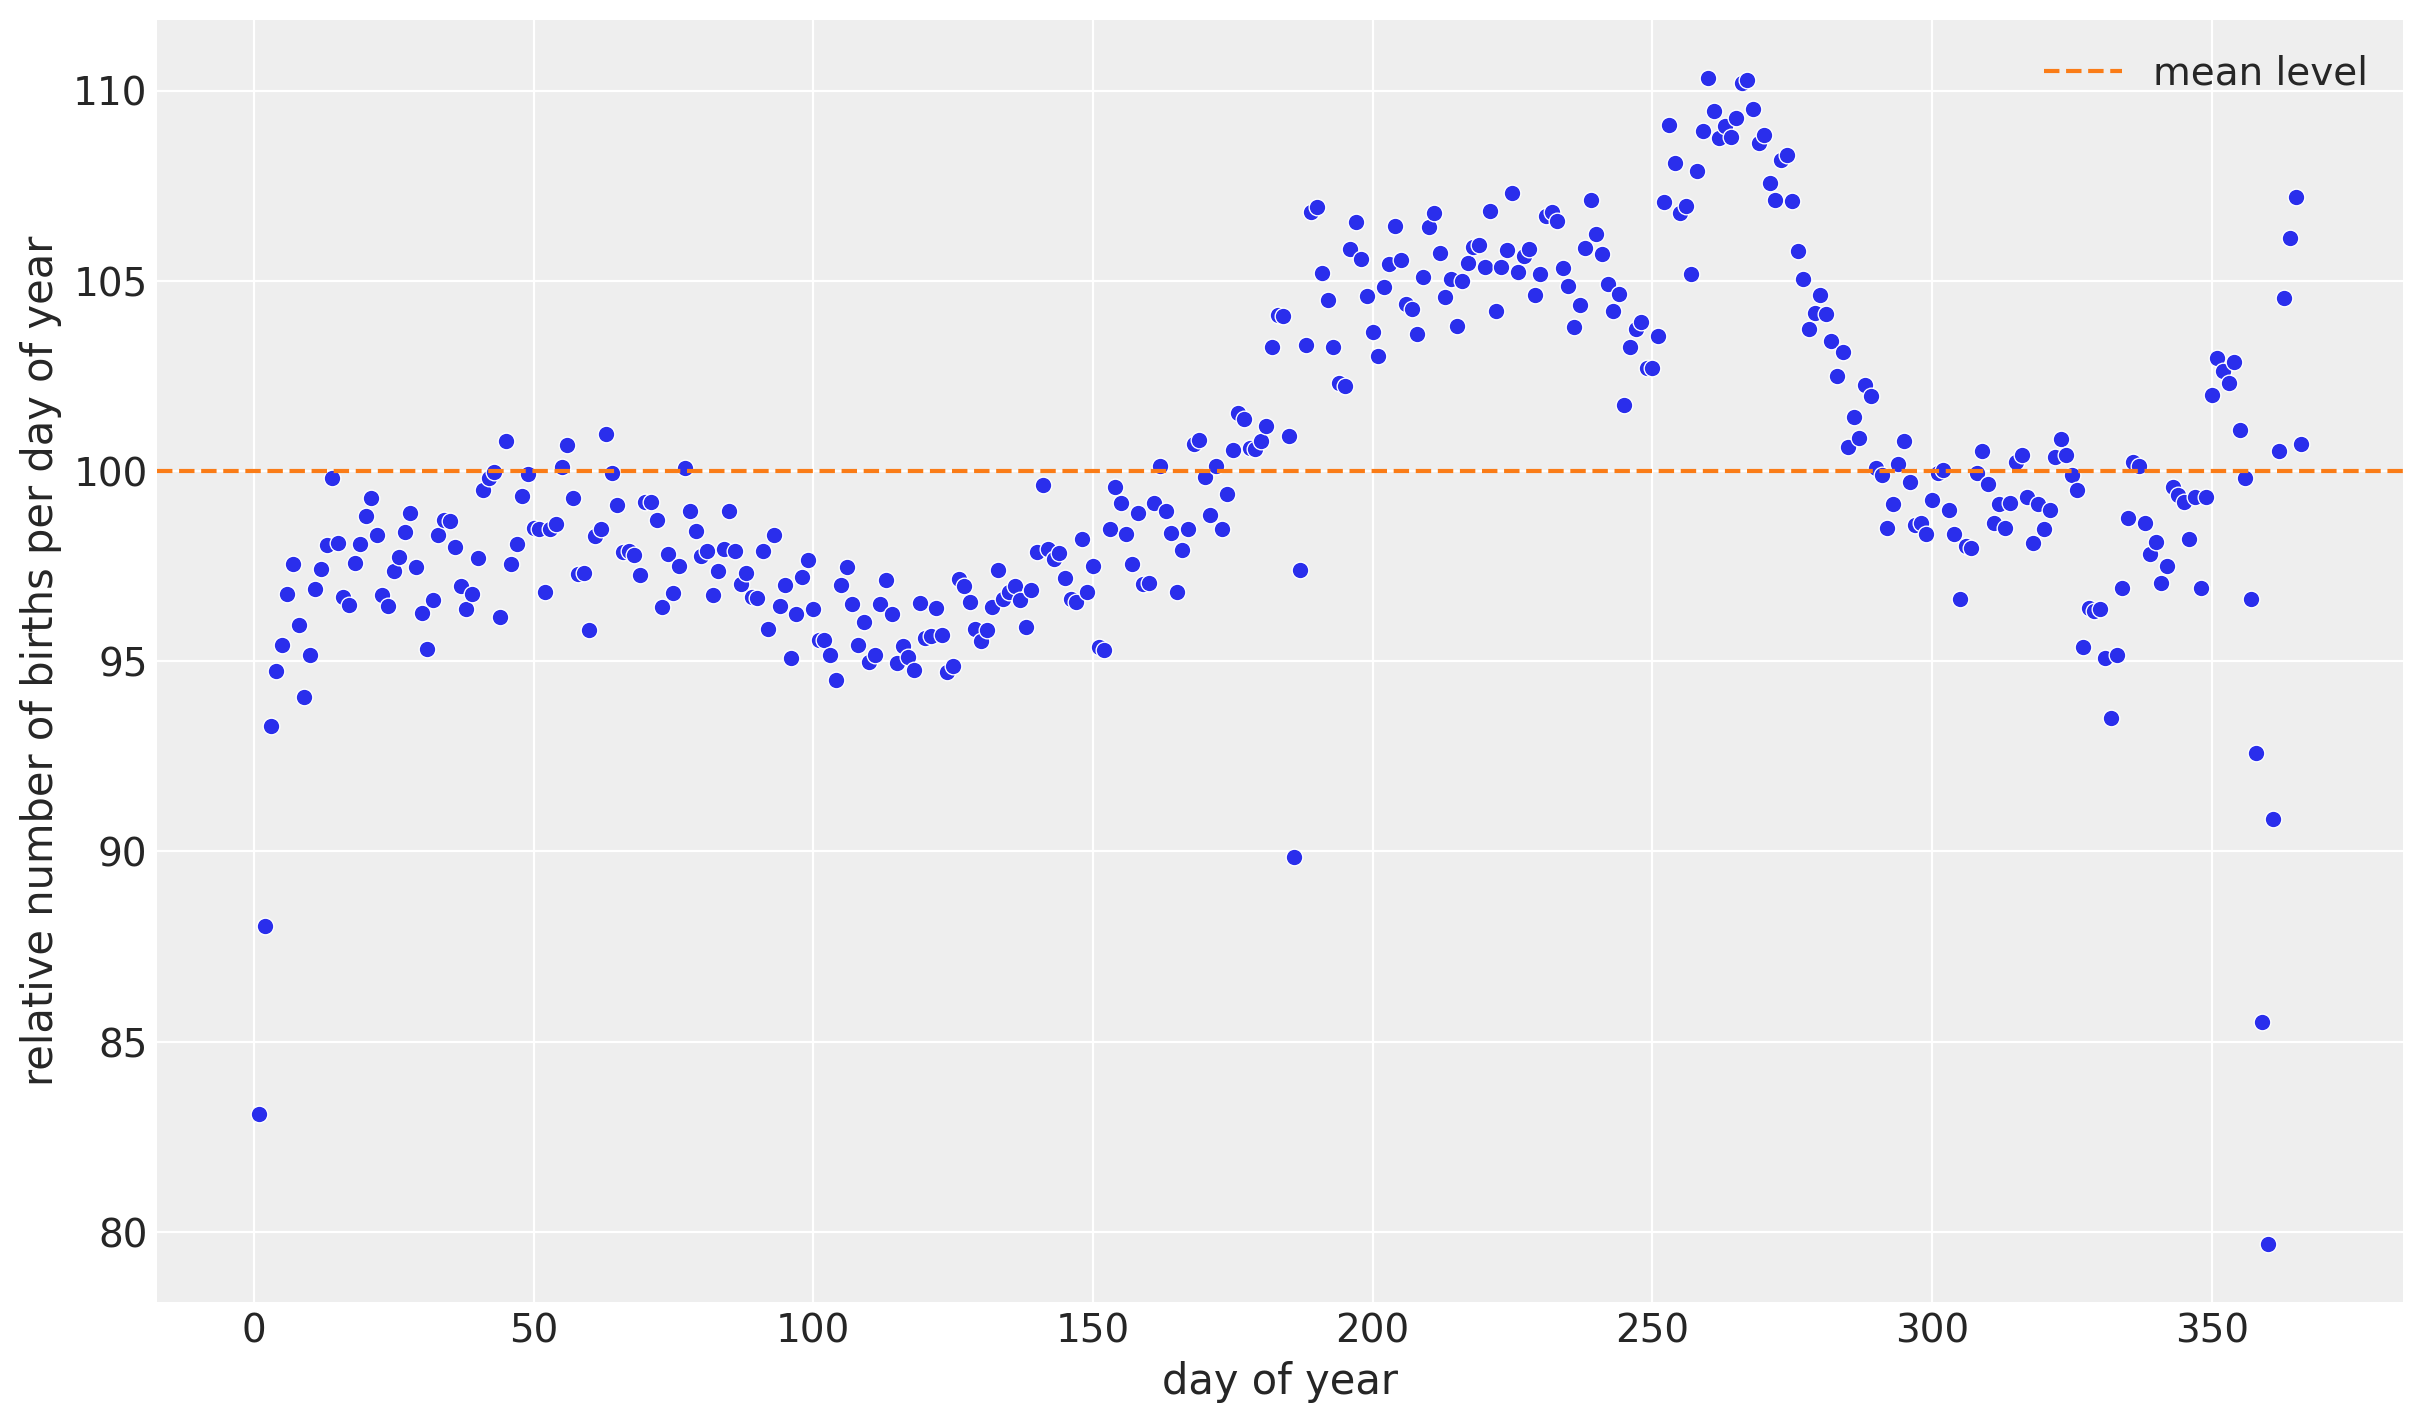

In [19]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_year2"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe((sns.scatterplot, "data"), x="day_of_year2", y="meanbirths", c="C0", ax=ax)
)
ax.axhline(100, color="C1", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of year", ylabel="relative number of births per day of year")

[Text(0.5, 0, 'day of week'),
 Text(0, 0.5, 'relative number of births per day of week')]

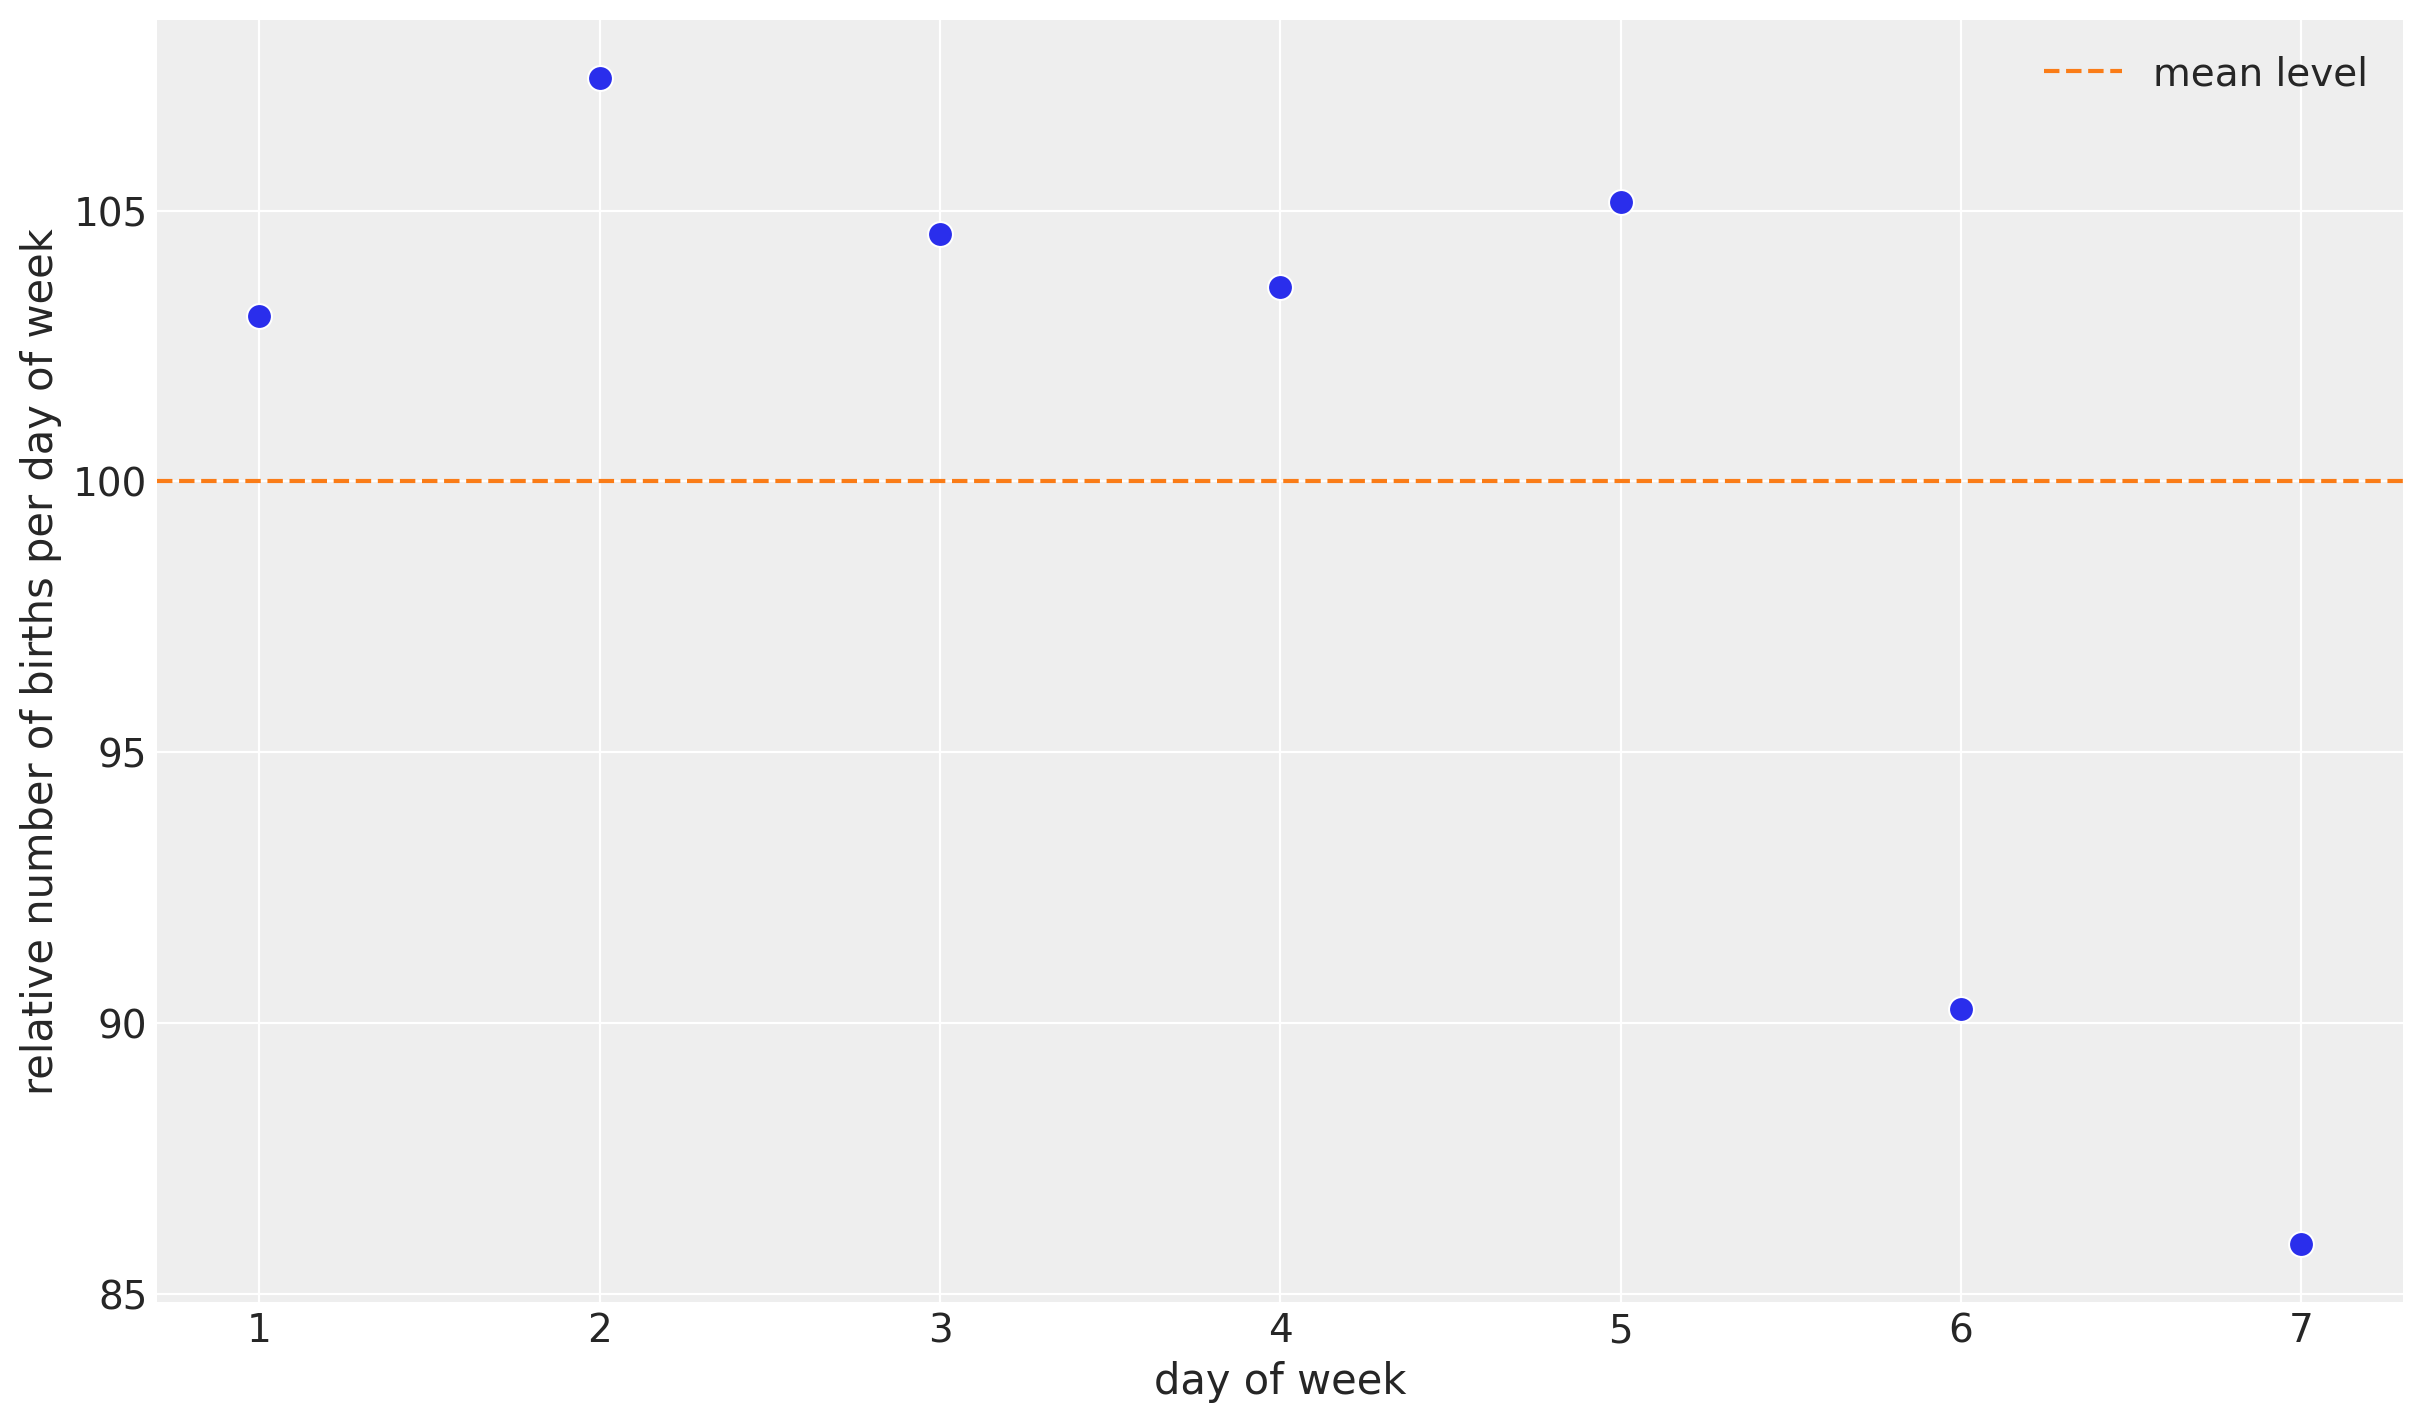

In [20]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_week"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe(
        (sns.scatterplot, "data"), x="day_of_week", y="meanbirths", c="C0", s=80, ax=ax
    )
)
ax.axhline(100, color="C1", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of week", ylabel="relative number of births per day of week")

In [21]:
n = data_df.shape[0]
obs = data_df.index.to_numpy()
year = data_df["year"].to_numpy()
day_of_week = data_df["day_of_week"].to_numpy()
day_of_year2 = data_df["day_of_year2"].to_numpy()
births_relative100 = data_df["births_relative100"].to_numpy()

In [67]:


obs_pipeline = Pipeline(steps=[("scaler", StandardScaler())])

obs_pipeline.fit(obs.reshape(-1, 1))
normalized_obs = obs_pipeline.transform(obs.reshape(-1, 1))

obs_std = obs_pipeline["scaler"].scale_.item()

births_relative100_pipeline = Pipeline(
    steps=[
        ("log", FunctionTransformer(func=np.log, inverse_func=np.exp)),
        ("scaler", StandardScaler()),
    ]
)

births_relative100_pipeline.fit(births_relative100.reshape(-1, 1))
normalized_log_births_relative100 = births_relative100_pipeline.transform(
    births_relative100.reshape(-1, 1)
)
normalized_log_births_relative100_std = births_relative100_pipeline[
    "scaler"
].scale_.item()

In [22]:
obs_std = obs.std()
normalized_obs = (obs - obs.mean()) / obs.std()


log_births_relative100 = np.log(births_relative100)
normalized_log_births_relative100 = (
    log_births_relative100 - log_births_relative100.mean()
) / log_births_relative100.std()

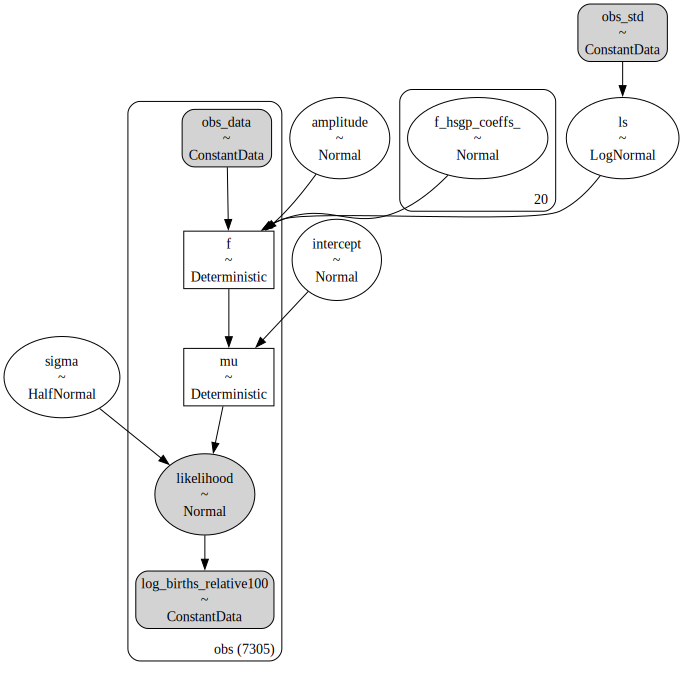

In [35]:
coords = {"obs": obs}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    obs_std_data = pm.Data(name="obs_std", value=obs_std, mutable=False)
    normalized_obs_data = pm.Data(
        name="obs_data", value=normalized_obs, mutable=False, dims="obs"
    )
    normalized_log_births_relative100_data = pm.Data(
        name="log_births_relative100",
        value=normalized_log_births_relative100,
        mutable=False,
        dims="obs",
    )

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)

    amplitude = pm.Normal(name="amplitude", mu=0, sigma=0.5)

    ls = pm.LogNormal(name="ls", mu=np.log(700 / obs_std_data), sigma=1)

    cov = amplitude**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls)

    gp_f = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov)

    f = gp_f.prior(name="f", X=normalized_obs_data[:, None], dims="obs")

    sigma = pm.HalfNormal(name="sigma", sigma=0.5)

    # --- Parametrization ---
    mu = pm.Deterministic(name="mu", var=intercept + f, dims="obs")

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=normalized_log_births_relative100_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

In [36]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

Sampling: [amplitude, f_hsgp_coeffs_, intercept, likelihood, ls, sigma]


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'Prior Predictive')

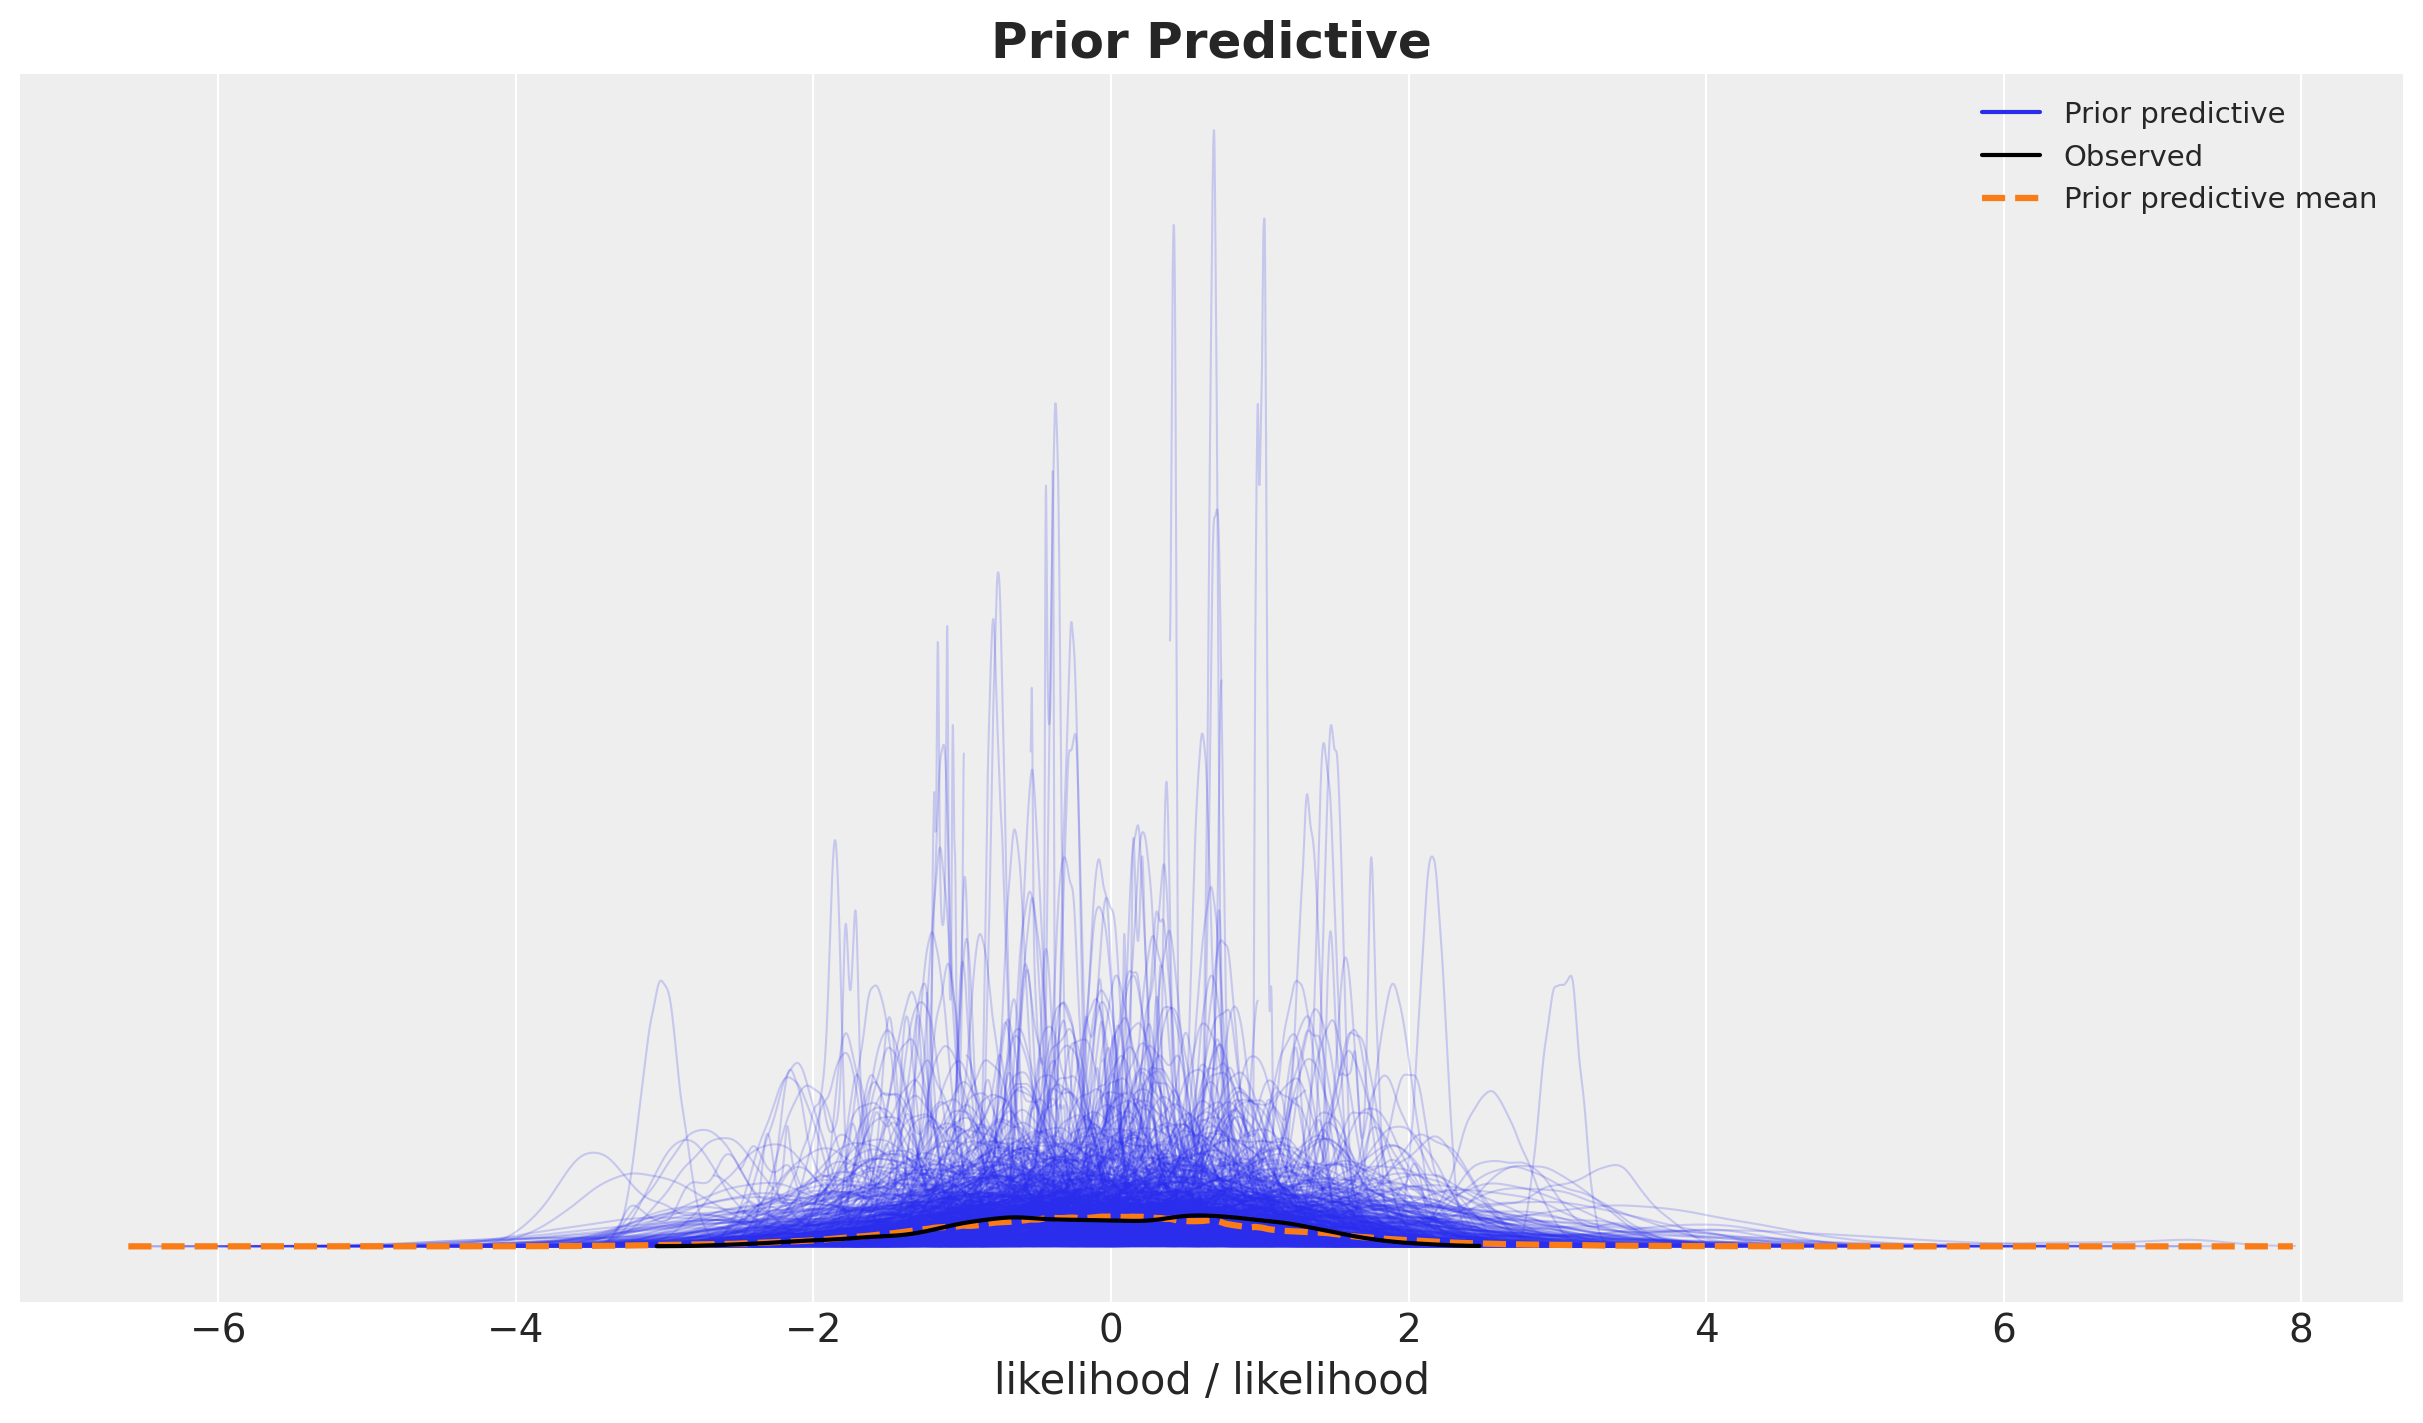

In [37]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")

In [38]:
with model:
    idata = pm.sample(
        target_accept=0.90,
        draws=2_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

Compiling...
Compilation time = 0:00:05.250535
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time = 0:01:10.414654
Transforming variables...
Transformation time = 0:00:02.358617
Sampling: [likelihood]


In [39]:
idata["sample_stats"]["diverging"].sum().item()

0

In [40]:
var_names = [
    "intercept",
    "amplitude",
    "ls",
    "sigma",
]

az.summary(data=idata, var_names=var_names, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.023,0.221,-0.381,0.452,0.003,0.003,5775.152,4438.315,1.000
amplitude,0.291,0.518,-0.701,0.837,0.252,0.192,7.128,29.485,1.529
ls,0.229,0.038,0.156,0.295,0.001,0.000,3217.035,3897.694,1.000
sigma,0.813,0.007,0.801,0.826,0.000,0.000,11165.292,5306.346,1.000


Text(0.5, 0.98, 'Rrace')

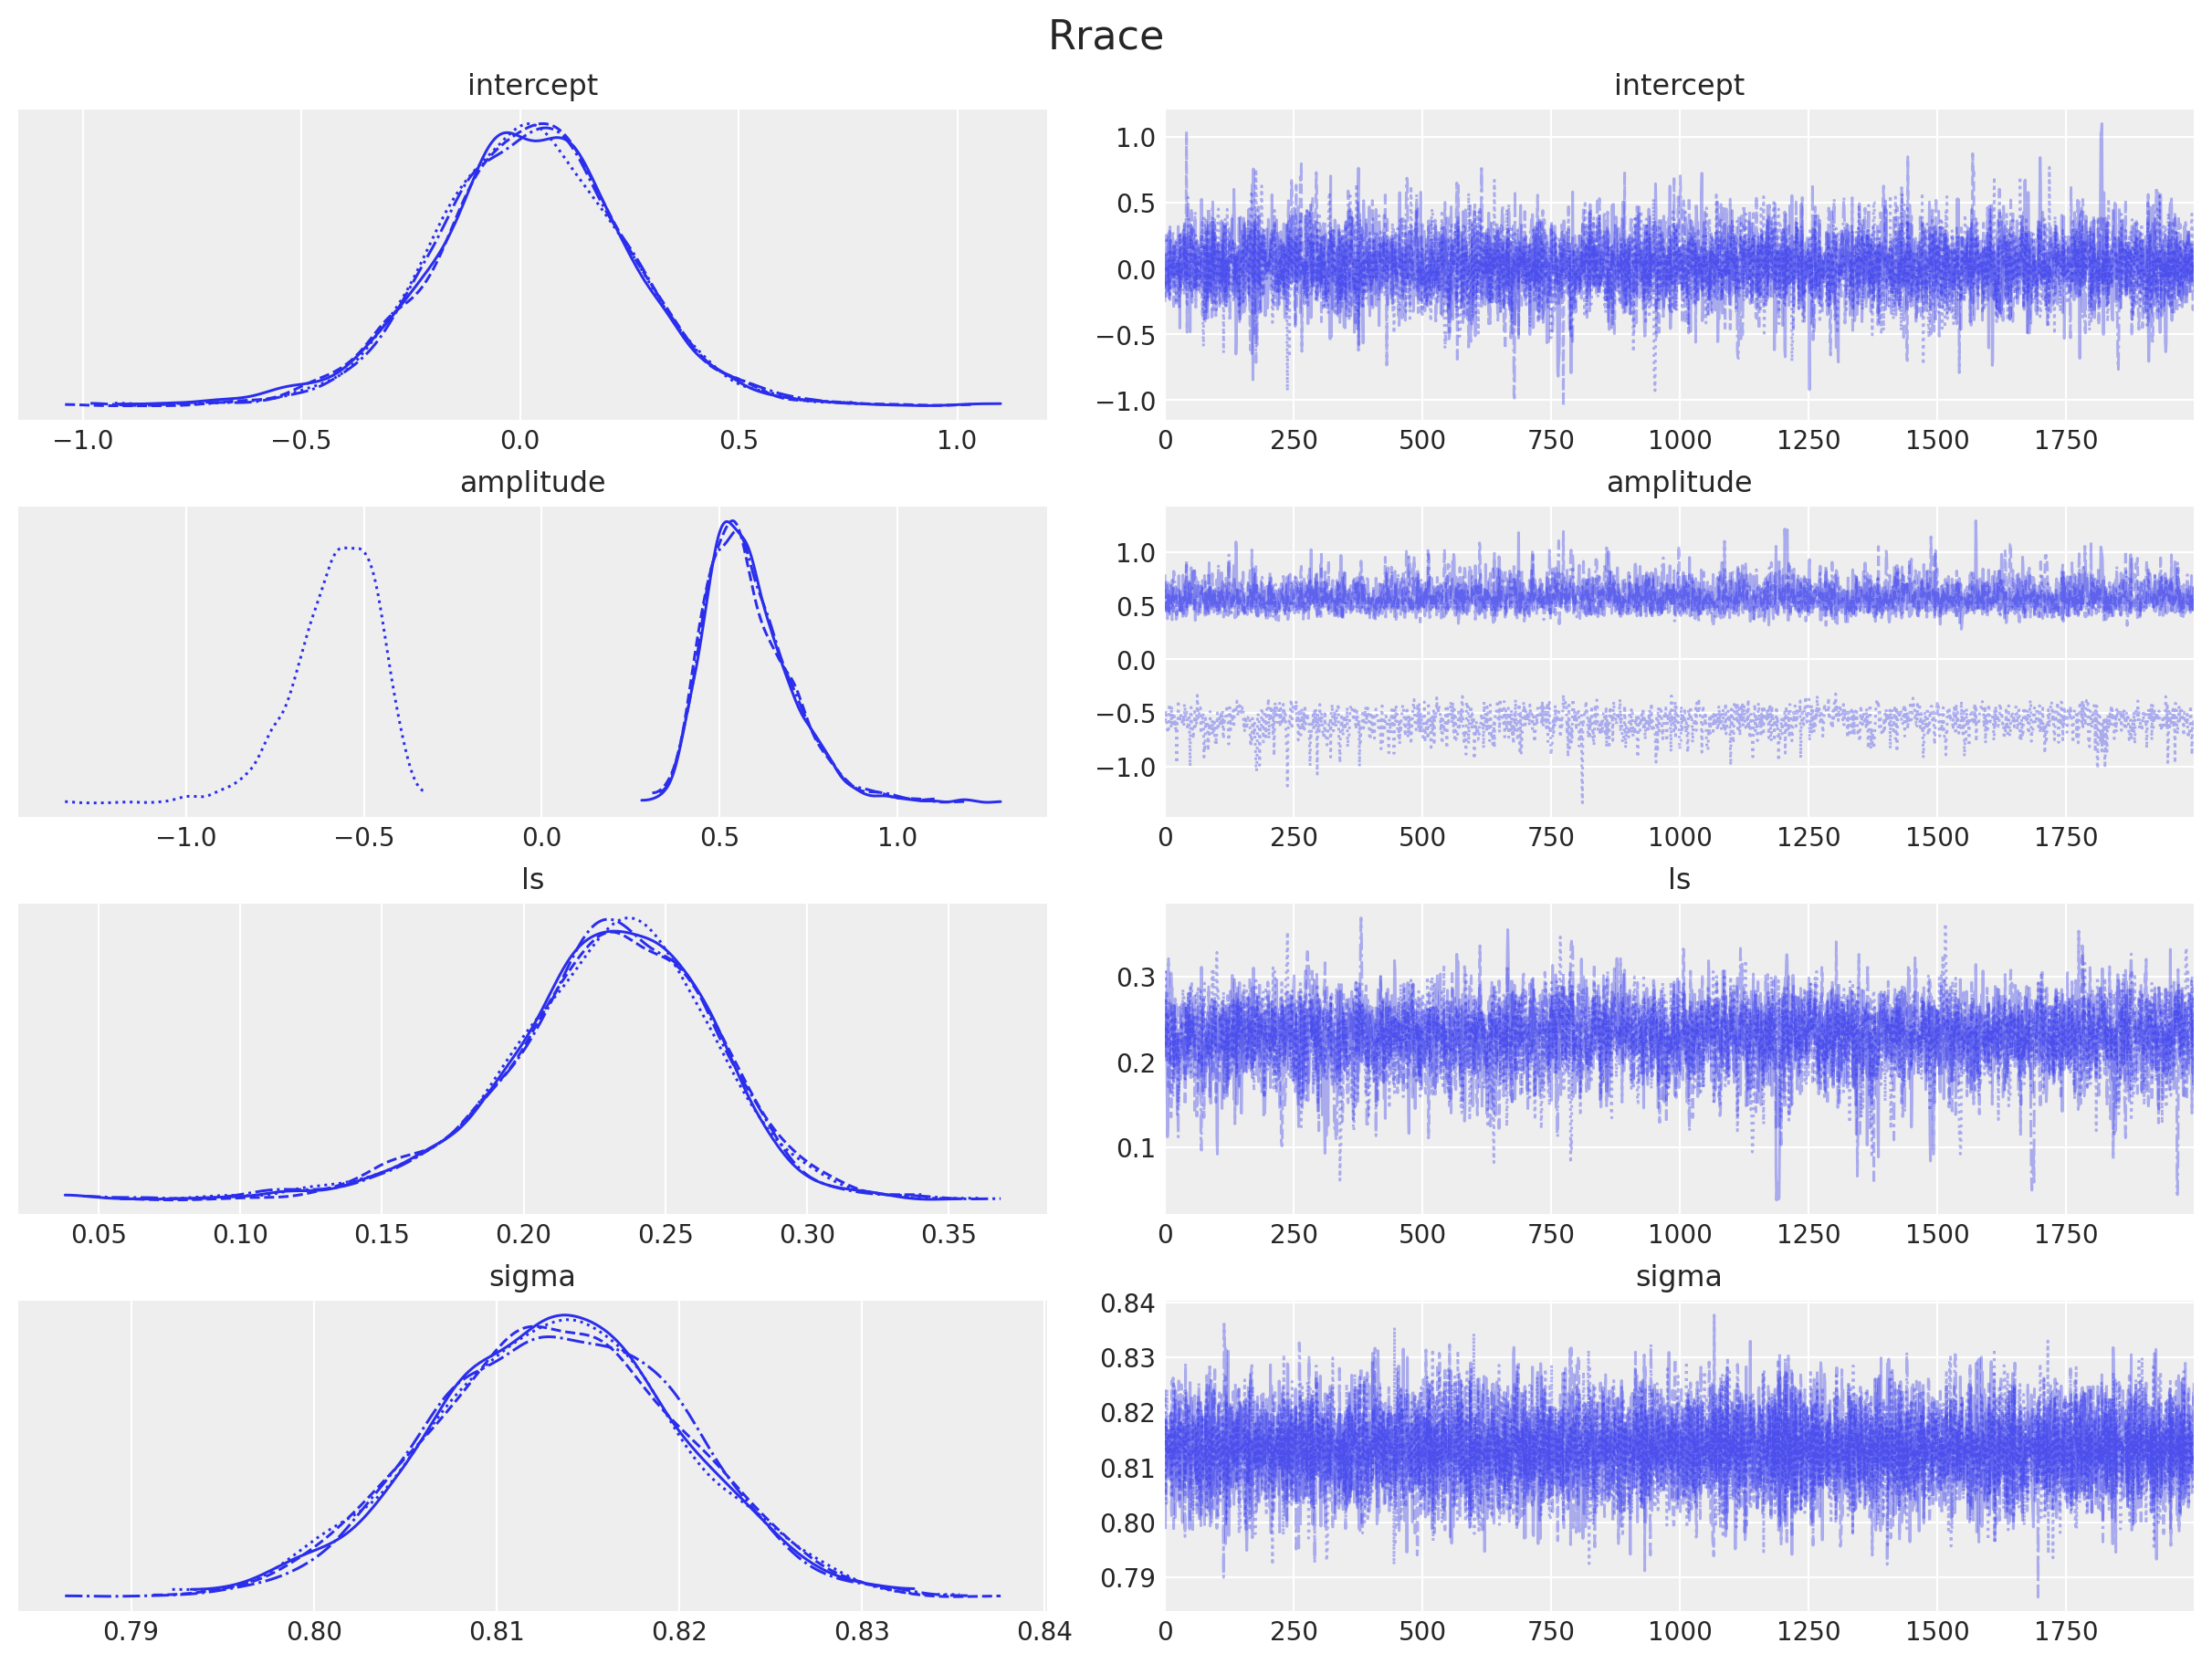

In [42]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Rrace", fontsize=16)

In [93]:
import xarray as xr

xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    posterior_predictive["posterior_predictive"]["likelihood"].expand_dims(
        dim={"d": 1}, axis=-1
    ),
    input_core_dims=[["obs", "d"]],
    output_core_dims=[["obs", "d"]],
    vectorize=True,
)

<xarray.DataArray 'likelihood' (chain: 4, draw: 2000, obs: 7305, d: 1)>
array([[[[ 97.70673079],
         [108.19636155],
         [ 84.43438833],
         ...,
         [132.29773079],
         [116.96950351],
         [132.65954663]],

        [[106.89790869],
         [107.21859953],
         [ 92.46781325],
         ...,
         [105.77583196],
         [131.19743156],
         [113.73333778]],

        [[ 89.60658956],
         [118.60705775],
         [100.95485064],
         ...,
...
         ...,
         [113.04129431],
         [108.10048787],
         [101.02938752]],

        [[107.74688284],
         [ 75.03206331],
         [ 94.00714513],
         ...,
         [111.15143002],
         [106.53831685],
         [120.37623003]],

        [[ 93.35421913],
         [ 98.43290188],
         [ 86.13525885],
         ...,
         [100.92048442],
         [122.14580571],
         [120.33471788]]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * obs      (obs) int64 0 1 2 3 4 5 6 7 ... 7298 7299 7300 7301 7302 7303 7304
Dimensions without coordinates: d

<xarray.DataArray 'likelihood' (chain: 4, draw: 2000, obs: 7305, d: 1)>
array([[[[-0.13769283],
         [ 0.72497792],
         [-1.37273457],
         ...,
         [ 2.42623203],
         [ 1.38452246],
         [ 2.44933584]],

        [[ 0.62284301],
         [ 0.64818311],
         [-0.60389113],
         ...,
         [ 0.53357737],
         [ 2.35558201],
         [ 1.14717865]],

        [[-0.86978619],
         [ 1.50213191],
         [ 0.13895576],
         ...,
...
         ...,
         [ 1.09554749],
         [ 0.71747862],
         [ 0.14519922]],

        [[ 0.68976178],
         [-2.37144953],
         [-0.46422432],
         ...,
         [ 0.95292402],
         [ 0.59433849],
         [ 1.62738318]],

        [[-0.52318429],
         [-0.07505349],
         [-1.20401886],
         ...,
         [ 0.13607558],
         [ 1.75083493],
         [ 1.62446541]]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * obs      (obs) int64 0 1 2 3 4 5 6 7 ... 7298 7299 7300 7301 7302 7303 7304
Dimensions without coordinates: d

<Axes: >

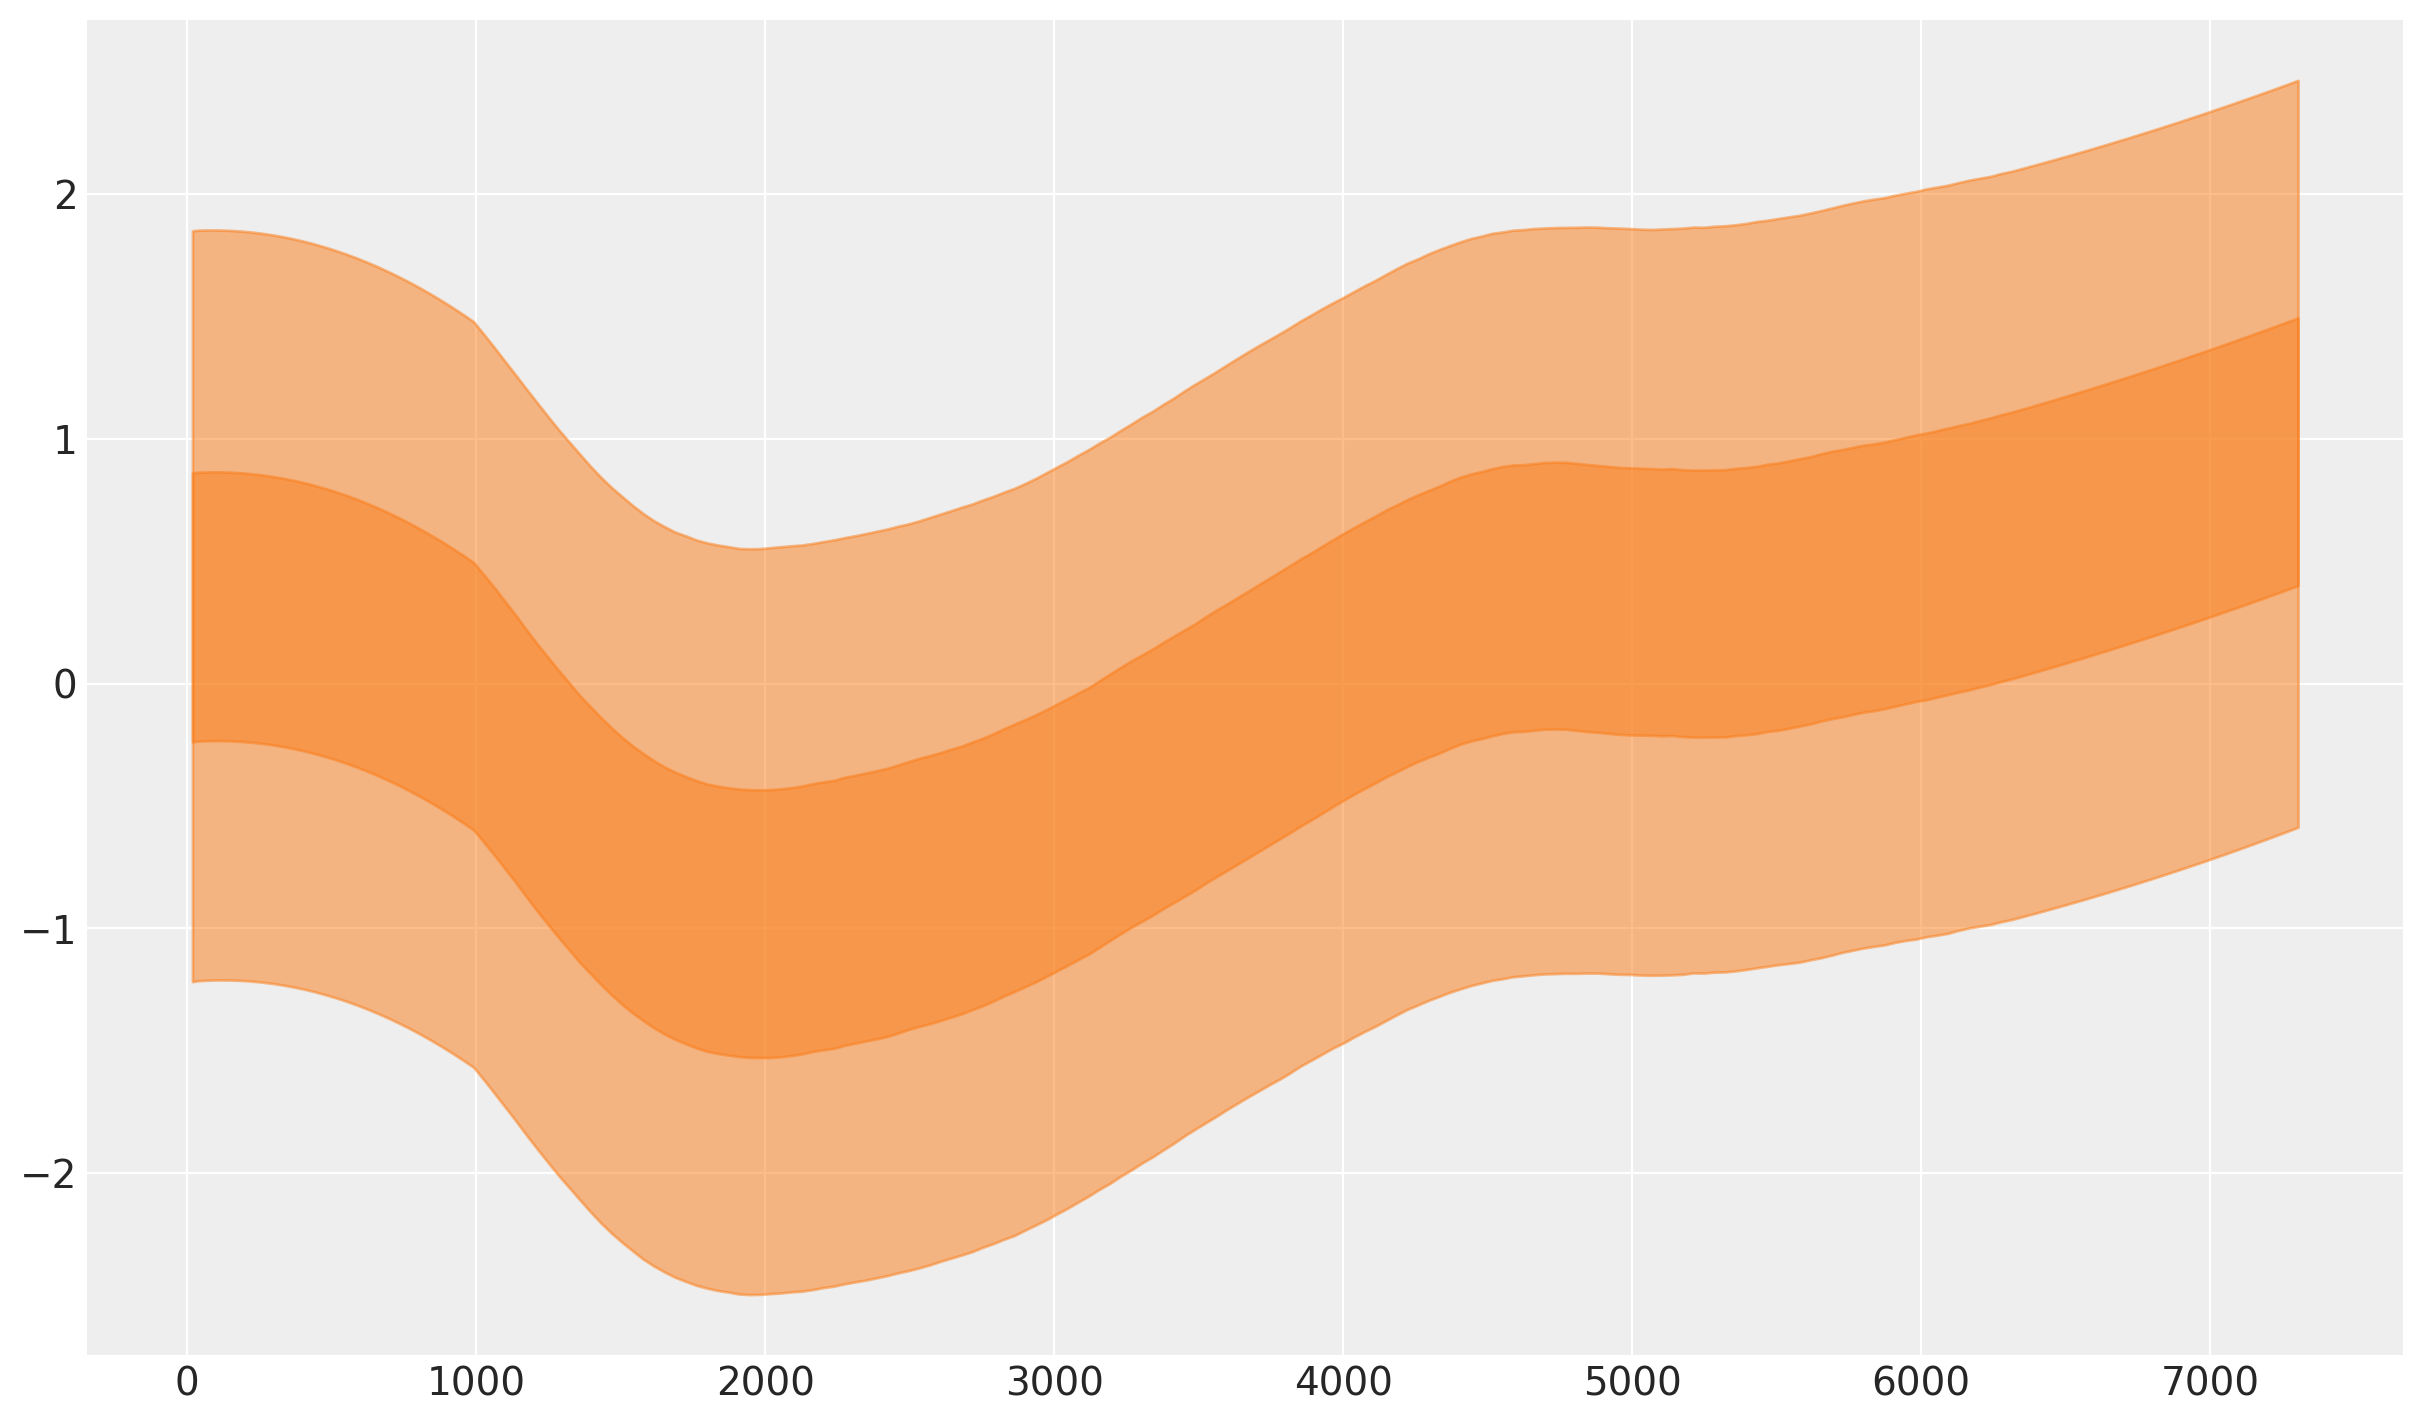

In [50]:
az.plot_hdi(
    x=obs, y=posterior_predictive["posterior_predictive"]["likelihood"], hdi_prob=0.94
)
az.plot_hdi(
    x=obs, y=posterior_predictive["posterior_predictive"]["likelihood"], hdi_prob=0.5
)